In [1]:
import numpy as np
import pandas as pd

In [2]:
!pip install statsmodels


In [3]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize


Step 1: check for the right sample size

In [4]:
#A/B test parameter
p1 = 0.12    # Baseline conversion rate (Group A)
p2 = 0.15    # Expected improvement (Group B)
alpha = 0.05  # Significance level (5%)
power = 0.80  # Power (80%)

In [5]:
# Effect size for proportion test
effect_size = proportion_effectsize(p1, p2)

In [6]:
#Power analysis
analysis = NormalIndPower()
required_n = int(np.ceil(analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha)))

In [7]:
print(f"Required sample size per group: {required_n}")

Required sample size per group: 2031


Step 2: Stimulate A/B testing

In [8]:
np.random.seed(42)

n_users_per_group = required_n
click_rate_A = p1
click_rate_B = p2

# Simulate binary clicks (1 = clicked, 0 = not clicked)
group_A_clicks = np.random.binomial(1, click_rate_A, n_users_per_group)
group_B_clicks = np.random.binomial(1, click_rate_B, n_users_per_group)

# Create DataFrames
df_A = pd.DataFrame({
    'user_id': range(1, n_users_per_group + 1),
    'group': 'A',
    'clicked': group_A_clicks
})

df_B = pd.DataFrame({
    'user_id': range(n_users_per_group + 1, 2 * n_users_per_group + 1),
    'group': 'B',
    'clicked': group_B_clicks
})

#combine two df 
df = pd.concat([df_A, df_B], ignore_index=True)

# Save to CSV
df.to_csv('ab_test_data.csv', index=False)

print("A/B test dataset created and saved as 'ab_test_data.csv'")
print(df.head())

A/B test dataset created and saved as 'ab_test_data.csv'
   user_id group  clicked
0        1     A        0
1        2     A        1
2        3     A        0
3        4     A        0
4        5     A        0


In [9]:
print(df.dtypes)

user_id     int64
group      object
clicked     int32
dtype: object


Step 3: Analyze data

In [10]:
#Calculate the conversion rate for each group
conversion_rate = df.groupby('group')['clicked'].mean()
print(conversion_rate)

group
A    0.119153
B    0.141802
Name: clicked, dtype: float64


In [15]:
from statsmodels.stats.proportion import proportions_ztest


#get click counts and total users for each group
clicks = df.groupby('group')['clicked'].sum().values
total_users = df.groupby('group')['clicked'].count().values 

# Run z-test for proportions
z_stat, p_value = proportions_ztest(count=clicks, nobs=total_users)

print("       Z-Test Results:")
print(f"Z-statistic: {z_stat:.3f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Statistically significant Group B performs better than Group A.")
else:
    print("Not statistically significant. No confident difference between A and B.")

       Z-Test Results:
Z-statistic: -2.143
P-value: 0.0321
Statistically significant Group B performs better than Group A.


Step 3: Visualizing A/B Test Results

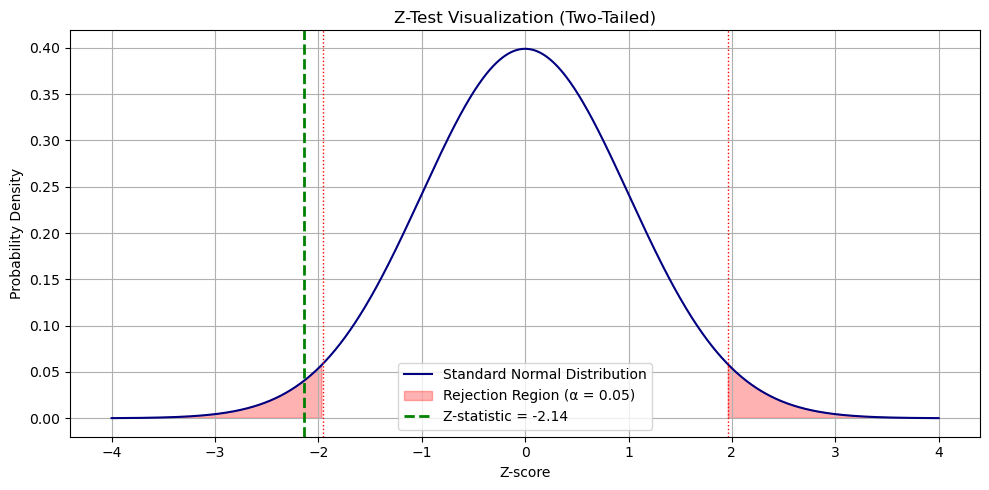

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# z-statistic from proportions_ztest
z_stat = -2.1427894968763677

# Critical z-value for 95% confidence (two-tailed test)
alpha = 0.05
z_crit = stats.norm.ppf(1 - alpha/2)

# X values for standard normal distribution
x = np.linspace(-4, 4, 1000)
y = stats.norm.pdf(x)

# Plot the normal distribution curve
plt.figure(figsize=(10, 5))
plt.plot(x, y, label='Standard Normal Distribution', color='navy')

# Rejection region shading
plt.fill_between(x, 0, y, where=(x <= -z_crit) | (x >= z_crit),
                 color='red', alpha=0.3, label='Rejection Region (α = 0.05)')

# Z-statistic line
plt.axvline(z_stat, color='green', linestyle='--', linewidth=2, label=f'Z-statistic = {z_stat:.2f}')
plt.axvline(-z_crit, color='red', linestyle=':', linewidth=1)
plt.axvline(z_crit, color='red', linestyle=':', linewidth=1)

# Labels and styling
plt.title("Z-Test Visualization (Two-Tailed)")
plt.xlabel("Z-score")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [14]:
import pandas as pd

summary = df.groupby('group')['clicked'].agg(
    Clicks='sum',
    Total_Users='count'
).reset_index()

summary['Conversion_Rate'] = (summary['Clicks'] / summary['Total_Users']).round(4)

summary['Conversion_Rate'] = (summary['Conversion_Rate'] * 100).astype(str) + '%'

summary.columns = ['Group', 'Clicks', 'Total Users', 'Conversion Rate']

summary


,Group,Clicks,Total Users,Conversion Rate
0,A,242,2031,11.92%
1,B,288,2031,14.180000000000001%
